# Geradin and Cardona test case

*This file provides a step by step explanation about how to generate a complete steady structural problem for SHARPy*

*Last modified March 2017, ADC (alfonso.del-carre14@imperial.ac.uk)*
[Aerolastics Lab](https://www.imperial.ac.uk/aeroelastics)
Imperial College London

In [1]:
# Necessary for inline plots in the notebook
%matplotlib inline 

# Necessary packages and imports
import h5py as h5
import numpy as np
import configparser

## Description

This case is a simple static cantilever beam, used as a test case by Geradin and Cardona in their book Flexible Multibody Dynamics.

The beam length is $L = 5$ m and its mass per unit length is $\bar{m} = 100$ kg/m. Its cross-sectional inertia is $J = 10$ kgm. Stiffness is: $EA = 4.8e8$ N, $GA = 3.231e8$ N, $GJ = 1e6$ N, $EI = 9.346e6$ Nm.

However, the test case is formulated so that the weight of the beam is not included. Only a -600kN dead vertical tip force will be applied. This will be modelled as a lumped mass at the tip with mass = 61183 kg

In [2]:
# parameters
length = 5
m_bar = 100*0       # we don't consider the dsitributed mass
j = 10

ea = 4.8e8
ga = 3.231e8
gj = 1e6
ei = 9.346e6

tip_lumped_mass = 600e3/9.81

For this simulation, we are going to use 10 3-noded elements. 

In [3]:
num_node_elem = 3
num_elem = 10
num_node = (num_node_elem - 1)*num_elem + 1

## Setup

A complete input file needs all the following information:
+ Nodal Coordinates
+ Connectivity information
+ Boundary Conditions
+ Structural Twist
+ Frame of Reference Definition
+ Beam Properties
+ Beam Number

---

### Nodal coordinates

Nodal coordinates are stored in a matrix with `x`, `y` and `z` columns, each of `size = num_node`:

In [4]:
x = np.linspace(0, length, num_node)  # very easy straight beam
y = np.zeros_like(x)
z = np.zeros_like(x)
coordinates = np.column_stack((x, y, z))

### Connectivities

Connectivities are given in a [num_elem, num_node_elem] matrix. The entry for a element like `0---1---2` would be `[0, 2, 1]` (always extrema first). For a two-noded elem like `0---1`, I'd be `[0, 1]`

In [5]:
conn = np.zeros((num_elem, num_node_elem), dtype=int)
for ielem in range(num_elem):
    conn[ielem, :] = (np.ones(3,))*ielem*(num_node_elem - 1) + [0, 2, 1]

### Boundary conditions
Boundary conditions are given in a integer vector with as many elements as nodes has the beam. All the nodes have to be 0, except the **clamped** nodes (1) or the **free** ones (-1).

In [6]:
boundary_conditions = np.zeros((num_node, 1), dtype=int)
boundary_conditions[0] = 1
boundary_conditions[-1]=-1

### Structural twist

SHARPy supports pre-twist in beams, which will be independent from the aerodynamic twist.
This angle is given for every node in a vector:
`structural_twist[inode] = twist (rad)`.
In our case, this is only zeroes.

In [7]:
structural_twist = np.zeros_like(x)

### Frame of reference definition
In order to define consistently the local (element) frame of reference, a vector has to be indicated. The resulting triad will be:
+ `x vector` in the direction of the increasing node order (tangent vector)
+ `y vector` in the plane defined by the x vector and the indicated one. The normal vector is chosen normal to the x vector, belonging to this plane and in the direction of the indicated vector.
+ `z vector` is chosen to have a right-handed FoR

For our case, where the beam is straight and in the x direction, the easiest way of indicating the vector is to input [0, 1, 0] in every node.
Note that it is not necessary to give unit vectors, they will be normalised later.

In [8]:
frame_of_reference_delta = np.zeros((num_node, 3))
for inode in range(num_node):
    frame_of_reference_delta[inode, :] = [0., 1., 0.]

### Beam properties description
Beam properties are stiffness and distributed inertia. The properties are assumed constant inside an element. These two are given by `6x6` diagonal matrices for this case:

Mass:
$\mathcal{M} = \text{diag}(\bar{m}, \bar{m}, \bar{m}, J_x, J_y, J_z)$

Stiffness:
$\mathcal{K} = \text{diag}(EA, GA, GA, GJ, EI_y, EI_z)$

Please note that the unit system is arbitrary but needs to be consistent. $\bar{m}$ denotes the mass per unit length.

---
In order not to repeat these `6x6` matrices, these are stored in a "dictionary". Then, for every element, only the index of where the matrix is stored is associated. It is easier with an example in mind. Our beam has constant properties, so the mass dictionary and the stiffness dictionary will have only one entry each:

In [9]:
num_stiffness = 1
stiffness = np.zeros((num_stiffness, 6, 6))
stiffness[0, :, :] = np.diag([ea, ga, ga, gj, ei, ei])  # this stiffness matrix is the "dictionary"
elem_stiffness = np.zeros((num_elem,), dtype=int)       # Every element has an integer associated which is the first index
                                                        # of the stiffness[:,:,:] matrix

In [10]:
# same for the mass
num_mass = 1
mass = np.zeros((num_mass, 6, 6))
mass[0, :, :] = np.diag([m_bar, m_bar, m_bar, j, j, j])
elem_mass = np.zeros((num_elem,), dtype=int)

### Beam number
Beam number is useful when running multibeam simulations. Basically it is a way of grouping beams together for easier post processing. Here, all the elements belong to beam no. 0. Please note that it is the __element__ that belongs to the beam, not the node.

In [11]:
beam_number = np.zeros((num_elem, 1), dtype=int)

### Lumped masses
Lumped masses are associated with a node, and they are defined with a `3x3` inertia matrix, a mass and a position given in __local__ (element) frame of reference (see Frame of reference definition).

Here, we are going to add a lumped point mass at the tip of the beam. Its inertia will be zero (because it is a point mass) and the mass is going to be `600e3/9.81` (see Problem description).

In [12]:
n_lumped_mass = 1
lumped_mass_nodes = np.array([num_node - 1], dtype=int)  # the first (and only) lumped mass is associated with the 
                                                         # num_node - 1 node, which is the last
lumped_mass = np.array([600e3/9.81])
lumped_mass_inertia = np.zeros((n_lumped_mass, 3, 3))
lumped_mass_position = np.zeros((n_lumped_mass, 3))

### Applied follower forces
There is also an option for applying static follower forces (in local frame of reference).
These are also applied over a node and expressed in local FoR. Every applied force/moment is given by 6 components: $F_x, F_y, F_z, M_x, M_y, M_z$.
Our case has none, but as an example:

In [13]:
#n_app_forces = 1
#node_app_forces = np.array([num_node - 1])
#app_forces = np.zeros((n_app_forces, 6))
#app_forces[0, :] = [0, 0, -1000, 0, 0, 0]

# if no forces:
n_app_forces = 0
node_app_forces = np.array([])
app_forces = np.zeros((n_app_forces, 6))

## HDF5 Export

The input format for the FEM information has to be in HDF5 format. [HDF5](https://support.hdfgroup.org/HDF5/) is a binary compressed data storage format. The main benefit for us is the ability of seamlessly export/import data written in different programming languages. In addition, several pieces of data can be stored in the same file, and the access in not sequential. These data are labeled and type information is embedded.

The cons of this format is that these files cannot be opened directly with your favourite text editor or MATLAB (at least directly). In order to see what is inside an `.h5` file, you need to write a script in any language supporting HDF5 (Fortran, C, C++, Java, Python, Julia, R, Matlab...), or use [HDFview](https://support.hdfgroup.org/products/java/release/download.html).

The process for writing a `h5` file is quite straightforward in Python. After storing all the information required in the variables we have been working with, you just need to do:
```python
handle = h5file.create_dataset('name_of_dataset', data=matrix_with_data)
```

The full process would be:

In [14]:
# First check that there are no geradin_cardona.fem.h5 files in the folder
# if there are any, delete them
import os
fem_file_name = './geradin_cardona.fem.h5'
if os.path.isfile(fem_file_name):
    os.remove(fem_file_name)

In [15]:
import h5py as h5  # already done at the top of the document
with h5.File('./geradin_cardona.fem.h5', 'a') as h5file:
    connectivities_handle = h5file.create_dataset('connectivities', data=conn)
    coordinates_handle = h5file.create_dataset('coordinates', data=coordinates)
    num_nodes_elem_handle = h5file.create_dataset('num_node_elem', data = num_node_elem)
    num_nodes_handle = h5file.create_dataset('num_node', data = num_node)
    num_elem_handle = h5file.create_dataset('num_elem', data = num_elem)
    stiffness_db_handle = h5file.create_dataset('stiffness_db', data = stiffness)
    stiffness_handle = h5file.create_dataset('elem_stiffness', data = elem_stiffness)
    mass_db_handle = h5file.create_dataset('mass_db', data = mass)
    mass_handle = h5file.create_dataset('elem_mass', data = elem_mass)
    frame_of_reference_delta_handle = h5file.create_dataset('frame_of_reference_delta', data=frame_of_reference_delta)
    structural_twist_handle = h5file.create_dataset('structural_twist', data=structural_twist)
    bocos_handle = h5file.create_dataset('boundary_conditions', data=boundary_conditions)
    beam_handle = h5file.create_dataset('beam_number', data=beam_number)
    app_forces_handle = h5file.create_dataset('app_forces', data=app_forces)
    node_app_forces_handle = h5file.create_dataset('node_app_forces', data=node_app_forces)
    lumped_mass_nodes_handle = h5file.create_dataset('lumped_mass_nodes', data=lumped_mass_nodes)
    lumped_mass_handle = h5file.create_dataset('lumped_mass', data=lumped_mass)
    lumped_mass_inertia_handle = h5file.create_dataset('lumped_mass_inertia', data=lumped_mass_inertia)
    lumped_mass_position_handle = h5file.create_dataset('lumped_mass_position', data=lumped_mass_position)

## Solver.txt file

The `solver.txt` file is the main settings file. This one is the first read by `SHARPy` and it controls the workflow of the program as well as the individual settings of each module.

The way of generating it is very similar to just writing it by hand:

In [16]:
file_name = './geradin_cardona.solver.txt'
config = configparser.ConfigParser()
config['SHARPy'] = {'case': 'geradin_cardona',
                    'route': './tests/beam/static/geradin_cardona',
                    'flow': 'NonLinearStatic, StaticPlot'}
config['NonLinearStatic'] = {'print_info': 'off',
                             'out_b_frame': 'off',
                             'out_a_frame': 'off',
                             'elem_proj': 2,
                             'max_iterations': 99,
                             'num_load_steps': 5,
                             'delta_curved': 1e-5,
                             'min_delta': 1e-5,
                             'newmark_damp': 0.000,
                             'gravity_on': 'on',
                             'gravity': 9.81,
                             'gravity_dir': '0, 0, 1'
                             }
config['StaticPlot'] = {'plot_shape': 'on',
                        'print_info': 'on'}

with open(file_name, 'w') as configfile:
    config.write(configfile)

This file is a simple text file generated with `configparser`.
The one we are going to use for this case looks like:
```
[SHARPy]
flow = NonLinearStatic, StaticPlot
case = geradin_cardona
route = ./tests/beam/static/geradin_cardona

[NonLinearStatic]
gravity = 9.81
elem_proj = 2
delta_curved = 1e-05
max_iterations = 99
gravity_dir = 0, 0, 1
min_delta = 1e-05
print_info = off
out_a_frame = off
num_load_steps = 5
gravity_on = on
out_b_frame = off
newmark_damp = 0.0

[StaticPlot]
print_info = on
plot_shape = on
```

---

The important points here are:
+ Every `solver.txt` file has a `[SHARPy]` heading containing the same information
    - `case`: a descriptive name for the case. It has to be the name of the `.fem.h5' file (without the extension).
    - `route`: where to find the input files.
    - `flow`: which modules have to be called, and in which order
+ The remaining headers (`NonLinearStatic` and `StaticPlot`) are the same names indicated in `[SHARPy][flow]`. When a module is created, these settings are gonna be passed to it.
+ Every module will in the future have its documentation concerning the different options and its defaults when applicable.

## Running the case

Running the case is as simple as executing from a terminal in the `sharpy` dir:
```bash
python __main__.py ./tests/beam/static/geradin_cardona/geradin_cardona.solver.txt
```
Or any other `.solver.txt` file from a case.

/home/ad214/Code/sharpy
--------------------------------------------------------------------------------
     ___           ___           ___           ___           ___
    /  /\         /__/\         /  /\         /  /\         /  /\        ___
   /  /:/_        \  \:\       /  /::\       /  /::\       /  /::\      /__/|
  /  /:/ /\        \__\:\     /  /:/\:\     /  /:/\:\     /  /:/\:\    |  |:|
 /  /:/ /::\   ___ /  /::\   /  /:/~/::\   /  /:/~/:/    /  /:/~/:/    |  |:|
/__/:/ /:/\:\ /__/\  /:/\:\ /__/:/ /:/\:\ /__/:/ /:/___ /__/:/ /:/   __|__|:|
\  \:\/:/~/:/ \  \:\/:/__\/ \  \:\/:/__\/ \  \:\/:::::/ \  \:\/:/   /__/::::\
 \  \::/ /:/   \  \::/       \  \::/       \  \::/~~~~   \  \::/       ~\~~\:\
  \__\/ /:/     \  \:\        \  \:\        \  \:\        \  \:\         \  \:\
    /__/:/       \  \:\        \  \:\        \  \:\        \  \:\         \__\/
    \__\/         \__\/         \__\/         \__\/         \__\/
----------------------------------------------------------

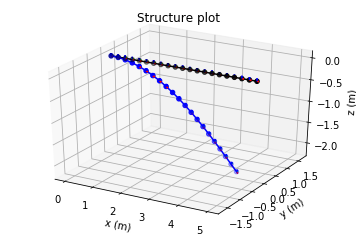

Tip:
	Pos_def:
		4.403530 0.000000 -2.159692 
	Psi_def:
		0.000000 0.672006 0.000000 
...Finished
FINISHED - Elapsed time = 1.2445917609999997 seconds


In [17]:
# change dir to the main sharpy one
%cd ../../../..
%pwd
# execute sharpy
%run __main__.py ./tests/beam/static/geradin_cardona/geradin_cardona.solver.txt